<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/7-ensemble-learning-and-random-forests/02_boosting_fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Boosting fundamentals

If you aggregate
the predictions of a group of predictors (such as classifiers or regressors), you will
often get better predictions than with the best individual predictor. A group of predictors
is called an ensemble; thus, this technique is called Ensemble Learning, and an
Ensemble Learning algorithm is called an Ensemble method.

Boosting (originally called hypothesis boosting) refers to any Ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor.

There are many boosting methods available, but by far the most popular are

* AdaBoost(short for Adaptive Boosting)
* Gradient Boosting

In fact, the winning solutions in Machine Learning competitions
often involve several Ensemble methods (most famously in the Netflix Prize
competition).



##Setup

In [49]:
# Common imports
import numpy as np
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor

import xgboost

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

from sklearn.datasets import make_moons
from sklearn.datasets import load_iris

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

In [4]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot, interpolation="nearest")
    plt.axis("off")

In [5]:
X, y = make_moons(n_samples=500, noise=0.5, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42)

##AdaBoost

One way for a new predictor to correct its predecessor is to pay a bit more attention
to the training instances that the predecessor underfitted. This results in new predictors
focusing more and more on the hard cases. This is the technique used by
AdaBoost.

Let's trains an `AdaBoost` classifier based on 200 Decision Stumps using
Scikit-Learn’s `AdaBoostClassifier` class (as you might expect, there is also an Ada
`BoostRegressor` class). 

A Decision Stump is a Decision Tree with `max_depth=1`—in
other words, a tree composed of a single decision node plus two leaf nodes. 

This is the default base estimator for the `AdaBoostClassifier` class:

In [6]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                             n_estimators=200,
                             algorithm="SAMME.R",
                             learning_rate=0.5,
                             random_state=42)

ada_clf.fit(x_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

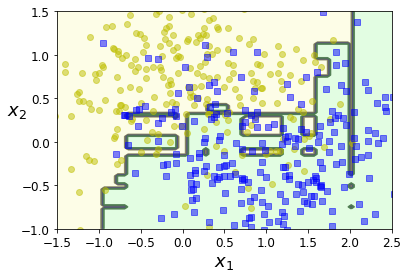

In [7]:
plot_decision_boundary(ada_clf, X, y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: No contour levels were found within the data range.
  # This is added back by InteractiveShellApp.init_path()


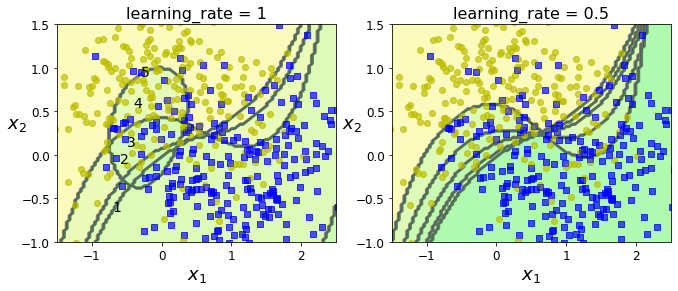

In [8]:
m = len(x_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="auto", random_state=42)
        svm_clf.fit(x_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(x_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

plt.show()

As you can see, this sequential learning technique has some
similarities with Gradient Descent, except that instead of tweaking a single predictor’s
parameters to minimize a cost function, AdaBoost adds predictors to the ensemble,
gradually making it better.

Once all predictors are trained, the ensemble makes predictions very much like bagging
or pasting, except that predictors have different weights depending on their
overall accuracy on the weighted training set.



##Gradient Boosting

Gradient Boosting works by sequentially adding predictors to an ensemble, each one
correcting its predecessor. However, instead of tweaking the instance weights at every
iteration like AdaBoost does, this method tries to fit the new predictor to the residual
errors made by the previous predictor.

Let’s go through a simple regression example, using Decision Trees as the base predictors.This is
called Gradient Tree Boosting, or Gradient Boosted Regression Trees (GBRT).

First, let’s
fit a `DecisionTreeRegressor` to the training set.

In [29]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [31]:
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Next, we’ll train a second `DecisionTreeRegressor` on the residual errors made by the first predictor:

In [32]:
y2 = y - tree_reg1.predict(X)

tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

Then we train a third regressor on the residual errors made by the second predictor:

In [33]:
y3 = y2 - tree_reg2.predict(X)

tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [34]:
X_new = np.array([[0.8]])

y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [35]:
y_pred

array([0.75026781])

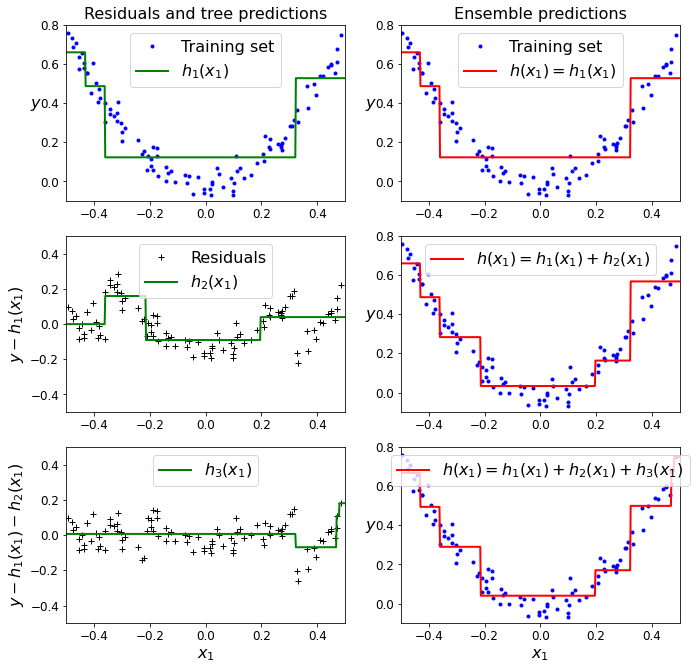

In [36]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

In the first row, the ensemble has just one
tree, so its predictions are exactly the same as the first tree’s predictions. 

In the second
row, a new tree is trained on the residual errors of the first tree. On the right you can
see that the ensemble’s predictions are equal to the sum of the predictions of the first
two trees. 

Similarly, in the third row another tree is trained on the residual errors of
the second tree. You can see that the ensemble’s predictions gradually get better as
trees are added to the ensemble.


A simpler way to train `GBRT` ensembles is to use Scikit-Learn’s `GradientBoostingRegressor` class. Much like the `RandomForestRegressor` class, it has hyperparameters to control the growth of Decision Trees (e.g., `max_depth, min_samples_leaf`), as well as `hyperparameters` to control the ensemble training, such as the number of trees (`n_estimators`).

In [38]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

The `learning_rate` hyperparameter scales the contribution of each tree. If you set it to a low value, such as 0.1, you will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better. This is a regularization technique
called shrinkage.

Let's check two GBRT ensembles trained with a low
learning rate: the one on the left does not have enough trees to fit the training set,
while the one on the right has too many trees and overfits the training set.

In [39]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

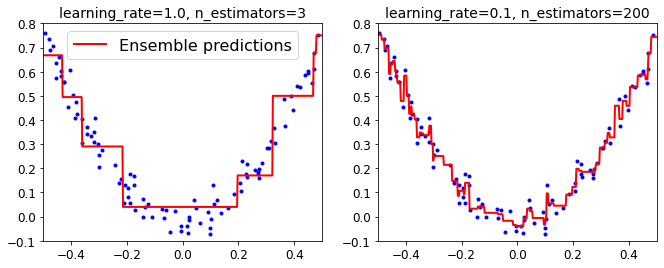

In [40]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()

##Gradient Boosting with Early stopping

In order to find the optimal number of trees, you can use early stopping.A simple way to implement this is to use the `staged_predict()` method: it
returns an iterator over the predictions made by the ensemble at each stage of training(with one tree, two trees, etc.).

let's trains a GBRT ensemble with
120 trees, then measures the validation error at each stage of training to find the optimal
number of trees, and finally trains another GBRT ensemble using the optimal
number of trees:

In [42]:
x_train, x_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(x_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(x_val)]
best_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators)
gbrt_best.fit(x_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=118)

In [43]:
min_error = np.min(errors)

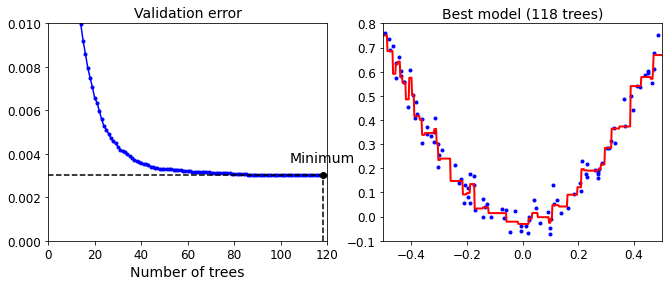

In [45]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([best_n_estimators, best_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(best_n_estimators, min_error, "ko")
plt.text(best_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % best_n_estimators, fontsize=14)

plt.show()

It is also possible to implement early stopping by actually stopping training early(instead of training a large number of trees first and then looking back to find the optimal number). You can do so by setting `warm_start=True`, which makes Scikit-Learn keep existing trees when the `fit()` method is called, allowing incremental training.

Let's stops training when the validation error does not
improve for five iterations in a row:

In [46]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0

for n_estimators in range(1, 120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(x_train, y_train)
  y_pred = gbrt.predict(x_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up += 1
    if error_going_up == 5:
      break   # early stopping

In [47]:
print(gbrt.n_estimators)

105


In [48]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.003023701609089896


The `GradientBoostingRegressor` class also supports a `subsample` hyperparameter, which specifies the fraction of training instances to be used for training each tree.

For example, if `subsample=0.25`, then each tree is trained on 25% of the training instances, selected randomly. 

As you can probably guess by now, this technique trades a
higher bias for a lower variance. It also speeds up training considerably. This is called **Stochastic Gradient Boosting**.



##XGBoost

It is worth noting that an optimized implementation of Gradient Boosting is available
in the popular Python library [XGBoost](https://github.com/dmlc/xgboost), which stands for Extreme Gradient Boosting.

In fact, `XGBoost` is often an important component of the winning
entries in ML competitions. XGBoost’s API is quite similar to Scikit-Learn’s:

In [50]:
xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(x_train, y_train)
y_pred = xgb_reg.predict(x_val)

[11:03:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [51]:
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error)

Validation MSE: 0.002965416676348418


`XGBoost` also offers several nice features, such as automatically taking care of early stopping:

In [ ]:
xgb_reg.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(x_val)

In [54]:
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error)

Validation MSE: 0.003141243312305123


##Stacking

0.8053333333333333